In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
from Codigo import *
import seaborn as sn
from statsmodels.stats.diagnostic import normal_ad
sn.set(style="whitegrid")

### Cargar Datos

In [16]:
Datos = Tachos('../Alemania_Reducida.csv')
data = Datos[['PIB (US$ a precios constantes de 2010)','Gasto de consumo final de los hogares (US$ a precios constantes de 2010)','Gasto nacional bruto (US$ a precios constantes de 2010)']].dropna(axis = 0)
data.columns = ['PIB','Inversión','Gasto']
data.dropna(axis =1, inplace= True)
data.index = pd.date_range(start='1970-12-31', periods=len(data), freq='Y')
#data['Inversión'] = np.log(data['Inversión'])
#data['Inversión'] = data['Inversión'].diff()
data.dropna(axis =0, inplace= True)

### Analisis de Estacionariedad a las Variables

In [17]:
DFuller(data['PIB'])
DFuller(data['Gasto'])
DFuller(data['Inversión'])

Estadístico ADF: -0.6667260211077259
Valor p: 0.8551810506341725
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: -0.6160967317000873
Valor p: 0.8673031853643212
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: -1.6102151214195712
Valor p: 0.47786271672686587
No podemos rechazar la hipótesis nula; la serie no es estacionaria.


### Amalisis de Correlacion de las Variables

### Analisis de Cointegración

In [18]:
print('Al 99% de confianza')
Johansen_Test(data,1,0,2)

Al 99% de confianza
Matriz de Valores Criticos vs Maximo Valor Propio
            cvm     eigv        Hipotesis
r = 0     2.7055    18.5001    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    11.5092    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    1.9887    No hay suficiente evidencia para rechazar la hipótesis nula de r = 2.
Tabla de Valores Criticos vs Traza Estadistica
            cvt     TS          Hipotesis
r = 0     2.7055    31.9981    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    13.498    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    1.9887    No hay suficiente evidencia para rechazar la hipótesis nula de r = 2.


### Modelo Inicial

In [19]:

lag_order = select_order(data, maxlags= 10, deterministic= 'n', seasons= 0)

print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 10, BIC -> 0, FPE -> 10, HQIC ->  10>


In [20]:
model = VECM(data ,coint_rank= 2, k_ar_diff= 10)
result = model.fit()
alpha_matrix = result.alpha
print("Matriz de Coeficientes de Corrección de Errores (alpha):")
print(alpha_matrix)


Matriz de Coeficientes de Corrección de Errores (alpha):
[[-0.11692322  1.38542498]
 [-0.03631507  0.08667444]
 [-0.00896661  0.45129364]]


In [21]:
print(result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation PIB
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.PIB           -0.9141      0.235     -3.893      0.000      -1.374      -0.454
L1.Inversión      0.1951      0.698      0.280      0.780      -1.172       1.563
L1.Gasto          0.8174      0.409      1.998      0.046       0.015       1.619
L2.PIB           -1.4526      0.264     -5.499      0.000      -1.970      -0.935
L2.Inversión     -0.8823      0.651     -1.354      0.176      -2.159       0.394
L2.Gasto          1.2191      0.408      2.984      0.003       0.419       2.020
L3.PIB           -1.1923      0.333     -3.585      0.000      -1.844      -0.540
L3.Inversión      2.5513      0.882      2.893      0.004       0.823       4.280
L3.Gasto          0.0258      0.484      0.053      0.958      -0.924       0.975
L4.PIB         

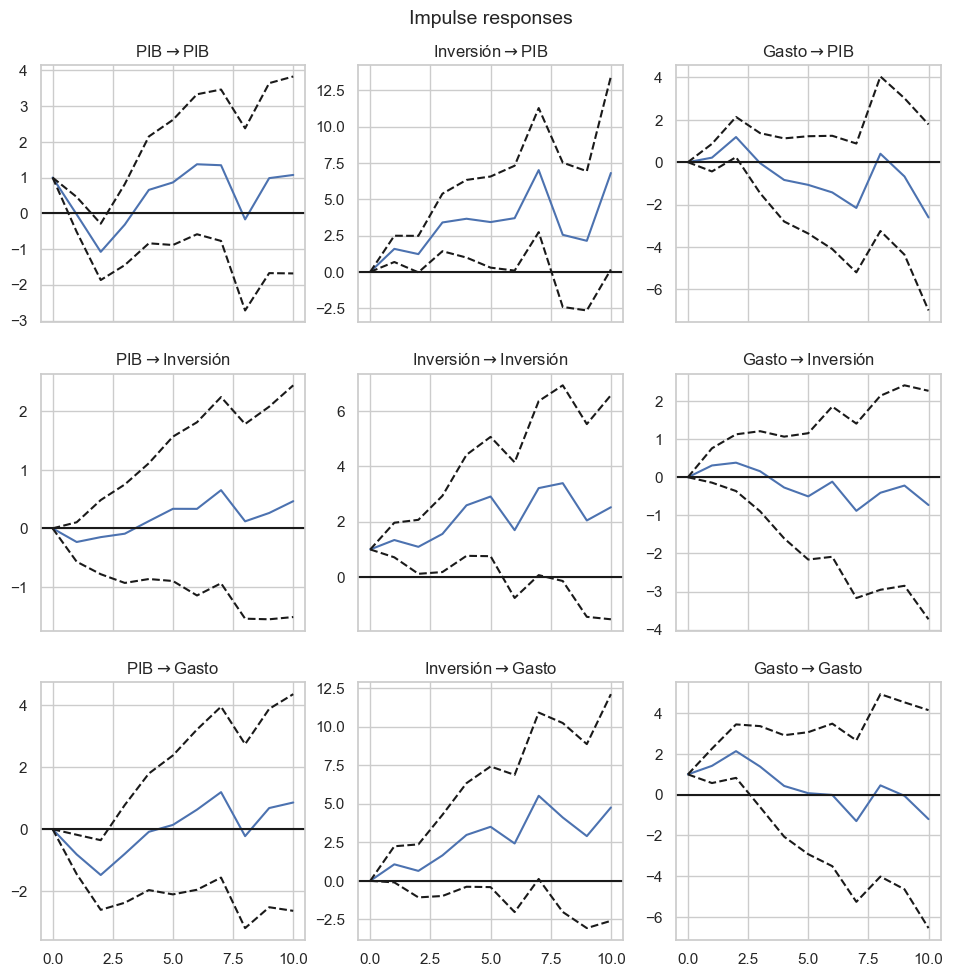

In [22]:
# Paso 6: Análisis de Impulsos-Respuestas
irf = result.irf(periods=10)
irf.plot()
plt.show()

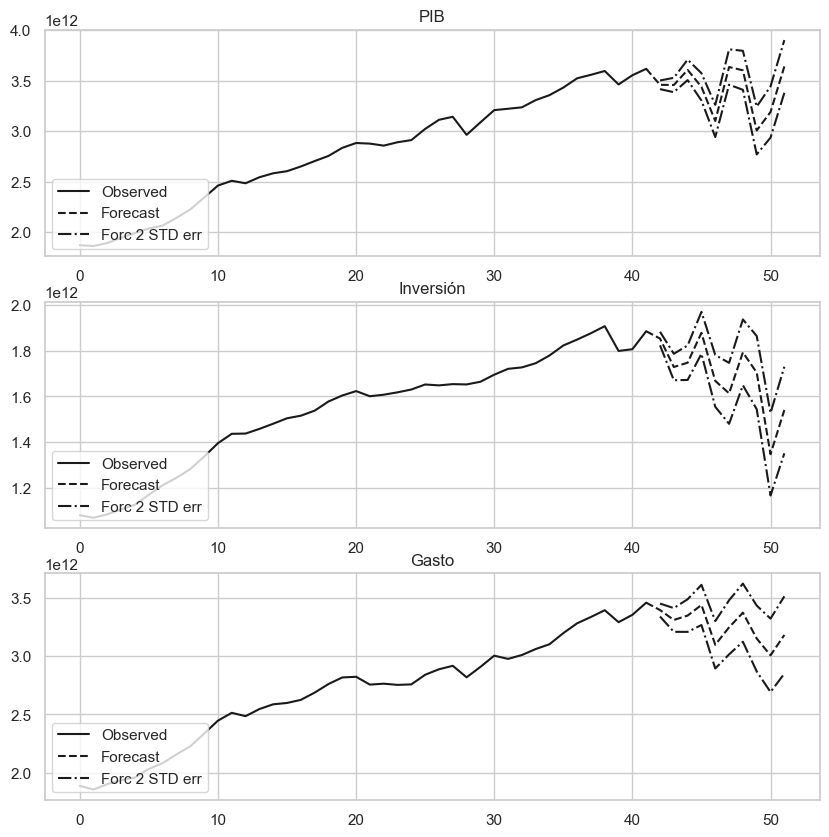

In [23]:
result.plot_forecast(steps = 10)

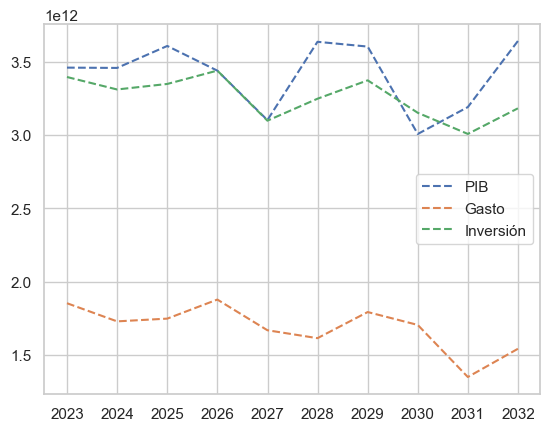

In [41]:
steps = 10
forecast, lower, upper = result.predict(steps, 0.05)
Fecha = pd.date_range(start=data.index[-1], periods=steps, freq='Y')
for i in range(len(data.columns)):
    t_pred = forecast[:,i]
    plt.plot(Fecha, t_pred, linestyle = '--')
plt.legend()
plt.show()

In [24]:

# Obtén los residuos
residuals = result.resid

# Realiza una prueba de normalidad de los residuos (por ejemplo, prueba Anderson-Darling)
ad_statistic, critical_values = normal_ad(residuals)

# Compara el estadístico con los valores críticos
for i in range(len(ad_statistic)):
    print(f'Anderson-Darling statistic: {ad_statistic[i]}, Critical value: {critical_values[i]}') # type: ignore

    # Compara el estadístico con el valor crítico
    if ad_statistic[i] > critical_values[i]: # type: ignore
        print(f'Se rechaza la hipótesis nula de normalidad para el estadístico {i + 1}.')
    else:
        print(f'No hay suficiente evidencia para rechazar la hipótesis nula de normalidad para el estadístico {i + 1}.')

Anderson-Darling statistic: 0.4295078136465591, Critical value: 0.2953069194115706
Se rechaza la hipótesis nula de normalidad para el estadístico 1.
Anderson-Darling statistic: 0.21621636632588093, Critical value: 0.8343845336569332
No hay suficiente evidencia para rechazar la hipótesis nula de normalidad para el estadístico 2.
Anderson-Darling statistic: 0.2967038449268884, Critical value: 0.5758604374523711
No hay suficiente evidencia para rechazar la hipótesis nula de normalidad para el estadístico 3.
